In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
train_image_path = glob.glob("./dataset/dc/train/*/*.jpg")

In [4]:
len(train_image_path)

2000

In [5]:
train_image_path[-5]

'./dataset/dc/train\\dog\\dog.995.jpg'

In [6]:
p = './dataset/dc/train\\cat\\cat.0.jpg'
p = p.split("\\")
int(p[1]=='cat')

1

In [7]:
# 如果是猫的话，就是1，是狗就是0
train_image_label = [int(path.split("\\")[1]=="cat") for path in train_image_path]

In [8]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [9]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [10]:
# 读取图片并解码函数
def load_preprosess_image(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 图像增强
    # 随机裁剪
    image = tf.image.random_crop(image, [256,256,3])
    # 左右翻转
    image = tf.image.random_flip_left_right(image)
    # 上下翻转
    image = tf.image.random_flip_up_down(image)
    # 改变亮度
    image = tf.image.random_brightness(image, 0.5)
    # 改变对比度
    image = tf.image.random_contrast(image, 0, 1)
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [11]:
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [12]:
# 根据计算机的cpu个数，进行计算
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_image_dataset = train_image_dataset.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [14]:
train_image_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

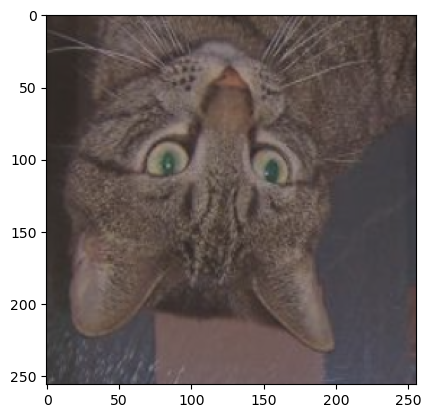

In [15]:
for img, label in train_image_dataset.take(2):
    plt.imshow(img)

In [16]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [17]:
train_image_dataset = train_image_dataset.shuffle(train_count).batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
train_image_dataset = train_image_dataset.prefetch(AUTOTUNE)

In [18]:
# 读取图片并解码函数
def load_preprosess_image_test(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [19]:
test_image_path = glob.glob("./dataset/dc/test/*/*.jpg")

In [20]:
test_image_label = [int(path.split("\\")[1]=="cat") for path in test_image_path]

In [21]:
test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))

In [22]:
test_image_dataset = test_image_dataset.map(load_preprosess_image_test, num_parallel_calls=AUTOTUNE)

In [23]:
test_image_dataset = test_image_dataset.batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
test_image_dataset = test_image_dataset.prefetch(AUTOTUNE)

In [24]:
test_count = len(test_image_path)
test_count

1000

### Keras中内置经典网络实现

In [25]:
covn_base = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3),
    pooling="avg"
)

83683744/83683744 [==============================] - 14s 0us/step


In [26]:
covn_base.trainable=False

In [27]:
covn_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

 block4_sepconv1_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block4_sepconv2_act (Activatio  (None, 32, 32, 728)  0          ['block4_sepconv1_bn[0][0]']     
 n)                                                                                               
                                                                                                  
 block4_sepconv2 (SeparableConv  (None, 32, 32, 728)  536536     ['block4_sepconv2_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block4_sepconv2_bn (BatchNorma  (None, 32, 32, 728)  2912       ['block4_sepconv2[0][0]']        
 lization)

 n)                                                                                               
                                                                                                  
 block7_sepconv1 (SeparableConv  (None, 16, 16, 728)  536536     ['block7_sepconv1_act[0][0]']    
 2D)                                                                                              
                                                                                                  
 block7_sepconv1_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block7_sepconv1[0][0]']        
 lization)                                                                                        
                                                                                                  
 block7_sepconv2_act (Activatio  (None, 16, 16, 728)  0          ['block7_sepconv1_bn[0][0]']     
 n)                                                                                               
          

 block9_sepconv3_bn (BatchNorma  (None, 16, 16, 728)  2912       ['block9_sepconv3[0][0]']        
 lization)                                                                                        
                                                                                                  
 add_7 (Add)                    (None, 16, 16, 728)  0           ['block9_sepconv3_bn[0][0]',     
                                                                  'add_6[0][0]']                  
                                                                                                  
 block10_sepconv1_act (Activati  (None, 16, 16, 728)  0          ['add_7[0][0]']                  
 on)                                                                                              
                                                                                                  
 block10_sepconv1 (SeparableCon  (None, 16, 16, 728)  536536     ['block10_sepconv1_act[0][0]']   
 v2D)     

                                                                                                  
 block12_sepconv3_act (Activati  (None, 16, 16, 728)  0          ['block12_sepconv2_bn[0][0]']    
 on)                                                                                              
                                                                                                  
 block12_sepconv3 (SeparableCon  (None, 16, 16, 728)  536536     ['block12_sepconv3_act[0][0]']   
 v2D)                                                                                             
                                                                                                  
 block12_sepconv3_bn (BatchNorm  (None, 16, 16, 728)  2912       ['block12_sepconv3[0][0]']       
 alization)                                                                                       
                                                                                                  
 add_10 (A

In [28]:
model = keras.Sequential()
model.add(covn_base)
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [30]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [31]:
initial_epochs = 5

In [ ]:
history = model.fit(
    train_image_dataset,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=initial_epochs,
    validation_data=test_image_dataset,
    validation_steps=test_count//BATCH_SIZE
)

In [33]:
covn_base.trainable=True

In [34]:
len(covn_base.layers)

133

In [35]:
fine_tune_at = -33

In [36]:
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable=False

In [37]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.005/10),
    loss="binary_corssentropy",
    metrics=["acc"]
)

In [38]:
initial_epochs = 33
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

In [ ]:
history = model.fit(
    train_image_dataset,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_dataset,
    validation_steps=test_count//BATCH_SIZE
)